In [37]:
import requests
import time
import pandas as pd
import numpy as np
from scipy import stats
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv(dotenv_path='/Users/irisyu/Desktop/Project/virtual-housing-agent/.env')

# Access the variables
DATA_API_KEY = os.getenv('DATA_API_KEY')
MAPS_API_KEY = os.getenv('PLACES_API_KEY')
GEOCODING_KEY = os.getenv('GEOCODING_API_KEY')

# Database

In [38]:
Data_URL = 'https://api.rentcast.io/v1/listings/rental/long-term'

In [39]:
params = {
    'city': 'San Francisco',
    'state': 'CA',
    'limit': 500,
    'status': 'Active', 
    'offset': 0
}

headers = {
    'Accept': 'application/json',
    'X-Api-Key': DATA_API_KEY
}

max_requests = 500  
all_listings = []
request_count = 0

In [40]:
try:
    for _ in range(max_requests):
        response = requests.get(Data_URL, headers=headers, params=params)
        request_count += 1
        
        if response.status_code == 200:
            listings = response.json() 
            if not isinstance(listings, list):
                print("Unexpected data format received.")
                break
            
            all_listings.extend(listings)
            
            print(f"Retrieved {len(listings)} rental listings. Total: {len(all_listings)}")
            
            if len(listings) < params['limit']:
                break
            
            params['offset'] += len(listings)
        else:
            print(f"Error: {response.status_code}")
            print(response.text)
            break
        
        time.sleep(1)

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

print(f"\nData retrieval completed.")
print(f"Total retrieved rental listings: {len(all_listings)}")
print(f"Total API requests made: {request_count}")


df = pd.DataFrame(all_listings)

Retrieved 500 rental listings. Total: 500
Retrieved 500 rental listings. Total: 1000
Retrieved 436 rental listings. Total: 1436

Data retrieval completed.
Total retrieved rental listings: 1436
Total API requests made: 3


In [41]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1436 non-null   object 
 1   formattedAddress  1436 non-null   object 
 2   addressLine1      1436 non-null   object 
 3   addressLine2      706 non-null    object 
 4   city              1436 non-null   object 
 5   state             1436 non-null   object 
 6   zipCode           1436 non-null   object 
 7   county            1436 non-null   object 
 8   latitude          1436 non-null   float64
 9   longitude         1436 non-null   float64
 10  propertyType      1436 non-null   object 
 11  bedrooms          1221 non-null   float64
 12  bathrooms         1389 non-null   float64
 13  squareFootage     830 non-null    float64
 14  lotSize           184 non-null    float64
 15  yearBuilt         414 non-null    float64
 16  status            1436 non-

In [42]:
df.head()

,id,formattedAddress,addressLine1,addressLine2,city,state,zipCode,county,latitude,longitude,...,squareFootage,lotSize,yearBuilt,status,price,listedDate,removedDate,createdDate,lastSeenDate,daysOnMarket
0,"88-King-St,-Unit-108,-San-Francisco,-CA-94107","88 King St, Unit 108, San Francisco, CA 94107",88 King St,Unit 108,San Francisco,CA,94107,San Francisco,37.780630,-122.389625,...,1194.0,82159.0,2000.0,Active,4990,2024-06-19T00:00:00.000Z,None,2022-01-07T01:40:35.638Z,2024-06-28T02:28:39.583Z,11
1,"747-Ellis-St,-Apt-11,-San-Francisco,-CA-94109","747 Ellis St, Apt 11, San Francisco, CA 94109",747 Ellis St,Apt 11,San Francisco,CA,94109,San Francisco,37.783794,-122.418472,...,505.0,NaN,NaN,Active,2345,2024-06-19T00:00:00.000Z,None,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.583Z,11
2,"245-30th-St,-San-Francisco,-CA-94131","245 30th St, San Francisco, CA 94131",245 30th St,None,San Francisco,CA,94131,San Francisco,37.742027,-122.425636,...,NaN,NaN,NaN,Active,2250,2024-06-21T00:00:00.000Z,None,2020-09-12T04:26:56.635Z,2024-06-28T02:28:39.582Z,9
3,"1598-Bay-St,-Unit-200,-San-Francisco,-CA-94123","1598 Bay St, Unit 200, San Francisco, CA 94123",1598 Bay St,Unit 200,San Francisco,CA,94123,San Francisco,37.803371,-122.433052,...,1399.0,NaN,NaN,Active,7950,2024-06-19T00:00:00.000Z,None,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.582Z,11
4,"2730-Sacramento-St,-Apt-11,-San-Francisco,-CA-...","2730 Sacramento St, Apt 11, San Francisco, CA ...",2730 Sacramento St,Apt 11,San Francisco,CA,94115,San Francisco,37.789555,-122.437874,...,825.0,NaN,NaN,Active,4895,2024-06-19T00:00:00.000Z,None,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.582Z,11


# Data Processing

In [43]:
columns_to_drop = ['id', 'addressLine1','addressLine2', 'state', 'lotSize','listedDate','removedDate']
df = df.drop(columns=columns_to_drop)

df = df.drop_duplicates()

df.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,yearBuilt,status,price,createdDate,lastSeenDate,daysOnMarket
0,"88 King St, Unit 108, San Francisco, CA 94107",San Francisco,94107,San Francisco,37.780630,-122.389625,Condo,2.0,2.0,1194.0,2000.0,Active,4990,2022-01-07T01:40:35.638Z,2024-06-28T02:28:39.583Z,11
1,"747 Ellis St, Apt 11, San Francisco, CA 94109",San Francisco,94109,San Francisco,37.783794,-122.418472,Apartment,1.0,1.0,505.0,NaN,Active,2345,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.583Z,11
2,"245 30th St, San Francisco, CA 94131",San Francisco,94131,San Francisco,37.742027,-122.425636,Apartment,1.0,1.0,NaN,NaN,Active,2250,2020-09-12T04:26:56.635Z,2024-06-28T02:28:39.582Z,9
3,"1598 Bay St, Unit 200, San Francisco, CA 94123",San Francisco,94123,San Francisco,37.803371,-122.433052,Condo,3.0,2.5,1399.0,NaN,Active,7950,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.582Z,11
4,"2730 Sacramento St, Apt 11, San Francisco, CA ...",San Francisco,94115,San Francisco,37.789555,-122.437874,Apartment,2.0,1.0,825.0,NaN,Active,4895,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.582Z,11


In [44]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    df[col] = df[col].fillna(0)


categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'addressLine2':
        df[col] = df[col].fillna("Unknown")


if 'removedDate' in df.columns:
    df['removedDate'] = df['removedDate'].fillna("Not Removed")


def remove_outliers(df, column):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores < 3]

for col in numeric_columns:
    df = remove_outliers(df, col)

df.head()

,formattedAddress,city,zipCode,county,latitude,longitude,propertyType,bedrooms,bathrooms,squareFootage,yearBuilt,status,price,createdDate,lastSeenDate,daysOnMarket
0,"88 King St, Unit 108, San Francisco, CA 94107",San Francisco,94107,San Francisco,37.780630,-122.389625,Condo,2.0,2.0,1194.0,2000.0,Active,4990,2022-01-07T01:40:35.638Z,2024-06-28T02:28:39.583Z,11
1,"747 Ellis St, Apt 11, San Francisco, CA 94109",San Francisco,94109,San Francisco,37.783794,-122.418472,Apartment,1.0,1.0,505.0,0.0,Active,2345,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.583Z,11
2,"245 30th St, San Francisco, CA 94131",San Francisco,94131,San Francisco,37.742027,-122.425636,Apartment,1.0,1.0,0.0,0.0,Active,2250,2020-09-12T04:26:56.635Z,2024-06-28T02:28:39.582Z,9
3,"1598 Bay St, Unit 200, San Francisco, CA 94123",San Francisco,94123,San Francisco,37.803371,-122.433052,Condo,3.0,2.5,1399.0,0.0,Active,7950,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.582Z,11
4,"2730 Sacramento St, Apt 11, San Francisco, CA ...",San Francisco,94115,San Francisco,37.789555,-122.437874,Apartment,2.0,1.0,825.0,0.0,Active,4895,2024-06-20T00:00:00.000Z,2024-06-28T02:28:39.582Z,11


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1308 entries, 0 to 1435
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formattedAddress  1308 non-null   object 
 1   city              1308 non-null   object 
 2   zipCode           1308 non-null   object 
 3   county            1308 non-null   object 
 4   latitude          1308 non-null   float64
 5   longitude         1308 non-null   float64
 6   propertyType      1308 non-null   object 
 7   bedrooms          1308 non-null   float64
 8   bathrooms         1308 non-null   float64
 9   squareFootage     1308 non-null   float64
 10  yearBuilt         1308 non-null   float64
 11  status            1308 non-null   object 
 12  price             1308 non-null   int64  
 13  createdDate       1308 non-null   object 
 14  lastSeenDate      1308 non-null   object 
 15  daysOnMarket      1308 non-null   int64  
dtypes: float64(6), int64(2), object(8)
memory usage

# Exploratory Data Analysis

In [46]:
df.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,yearBuilt,price,daysOnMarket
count,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000,1308.000000
mean,37.779690,-122.421314,1.231651,1.154052,477.934251,546.512232,3384.578746,118.607034
std,0.017091,0.019706,0.967256,0.451308,558.857925,882.428613,1405.970064,134.962570
min,37.719715,-122.490518,0.000000,0.000000,0.000000,0.000000,995.000000,1.000000
25%,37.772685,-122.429910,1.000000,1.000000,0.000000,0.000000,2395.000000,18.000000
50%,37.784264,-122.418362,1.000000,1.000000,400.000000,0.000000,3100.000000,64.000000
75%,37.790819,-122.410484,2.000000,1.000000,800.000000,1907.250000,4100.000000,151.250000
max,37.811424,-122.365562,4.000000,2.500000,4557.000000,2023.000000,8551.000000,366.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


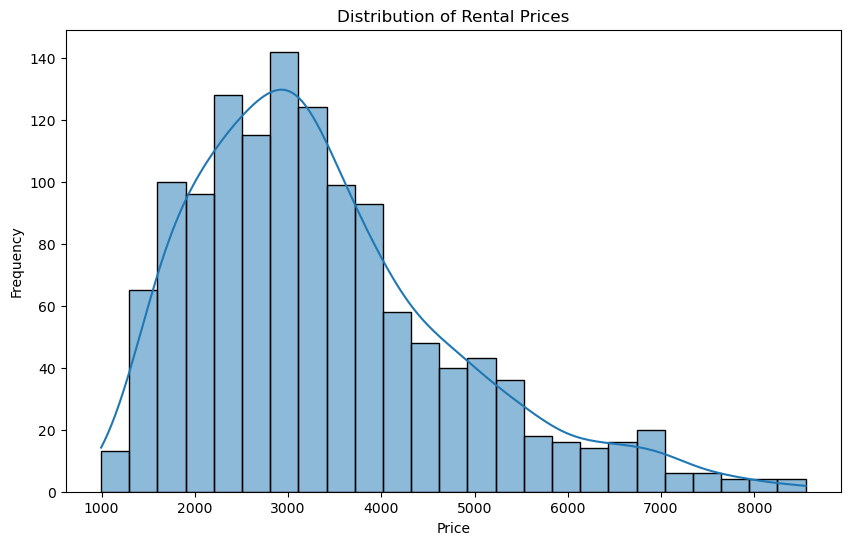

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


#Rent Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

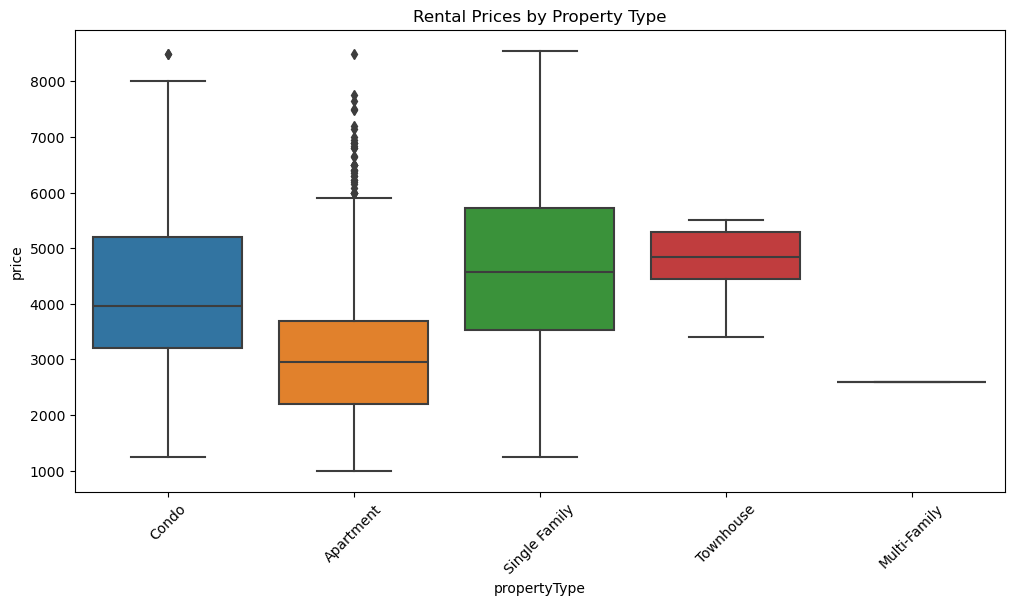

In [48]:
# Rent Price across Property Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='propertyType', y='price', data=df)
plt.title('Rental Prices by Property Type')
plt.xticks(rotation=45)
plt.show()

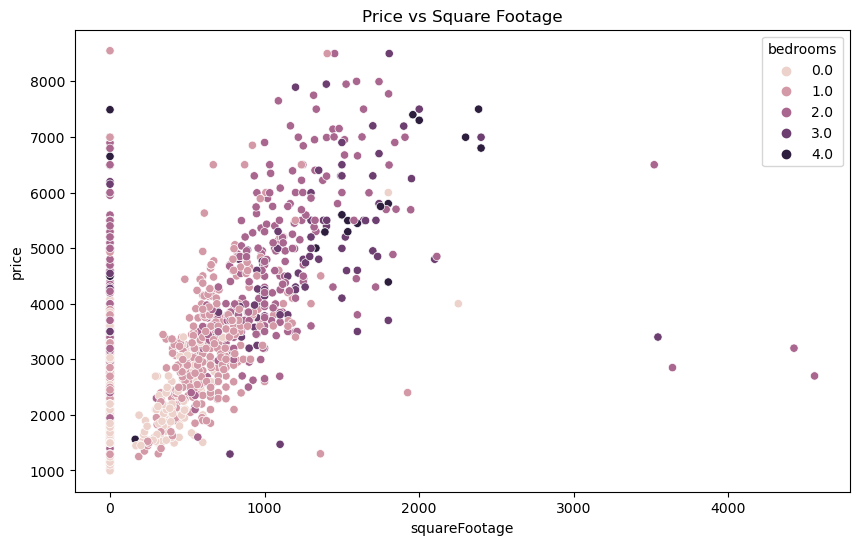

In [49]:
# Price vs Square Footage
plt.figure(figsize=(10, 6))
sns.scatterplot(x='squareFootage', y='price', hue='bedrooms', data=df)
plt.title('Price vs Square Footage')
plt.show()

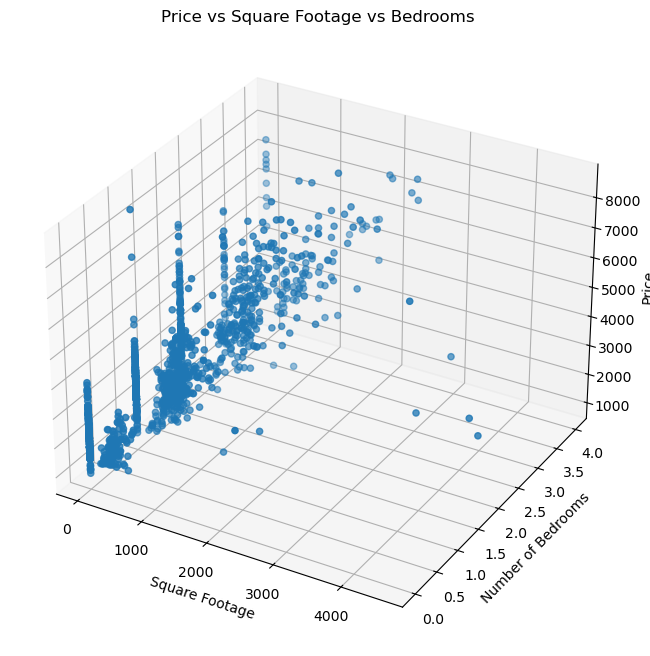

In [50]:
#Price vs Square Footage vs Bedrooms
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['squareFootage'], df['bedrooms'], df['price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('Number of Bedrooms')
ax.set_zlabel('Price')
plt.title('Price vs Square Footage vs Bedrooms')
plt.show()

In [51]:
import folium
from folium.plugins import MarkerCluster
import webbrowser
import os


sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

marker_cluster = MarkerCluster().add_to(sf_map)

def get_color(price):
    if price < 2000:
        return 'green'
    elif price < 3000:
        return 'yellow'
    elif price < 4000:
        return 'orange'
    else:
        return 'red'


for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"Price: ${row['price']}, Bedrooms: {row['bedrooms']}",
        color=get_color(row['price']),
        fill=True,
        fillColor=get_color(row['price'])
    ).add_to(marker_cluster)

legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 120px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp; Price Legend <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i> &lt; $2000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:yellow"></i> $2000-$3000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:orange"></i> $3000-$4000 <br>
     &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i> &gt; $4000
</div>
'''
sf_map.get_root().html.add_child(folium.Element(legend_html))


map_file = "sf_rentals_map.html"
sf_map.save(map_file)


file_path = os.path.abspath(map_file)


webbrowser.open('file://' + file_path)

True

# Connect with Google Maps Geocoding API

In [54]:
import googlemaps

gmaps_places = googlemaps.Client(key=MAPS_API_KEY)
gmaps_geocoding = googlemaps.Client(key=GEOCODING_KEY)

def autocomplete_place(input_text):
    predictions = gmaps_places.places_autocomplete(input_text, types='geocode')
    return predictions

def get_lat_lng_from_place_id(place_id):
    result = gmaps_geocoding.place(place_id=place_id)
    location = result['result']['geometry']['location']
    return location['lat'], location['lng']


# Hard Metric Classification Recommendation System

In [55]:
import math

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return R * c

def filter_listings(df, bedrooms, bathrooms, min_rent, max_rent, location, move_in_date, lease_term, max_distance_km):
    filtered_df = df[
        (df['bedrooms'] >= bedrooms) &
        (df['bathrooms'] >= bathrooms) &
        (df['price'] >= min_rent) &
        (df['price'] <= max_rent)
    ]
    
    predictions = autocomplete_place(location)
    if predictions:
        place_id = predictions[0]['place_id']
        lat, lng = get_lat_lng_from_place_id(place_id)
        
        filtered_df['distance'] = filtered_df.apply(lambda row: haversine(lat, lng, row['latitude'], row['longitude']), axis=1)
        filtered_df = filtered_df[filtered_df['distance'] <= max_distance_km]
    
    return filtered_df

def display_results(filtered_df):
    if filtered_df.empty:
        print("No listings found that match your criteria.")
    else:
        print(f"Found {len(filtered_df)} listings that match your criteria:")
        print(filtered_df[['formattedAddress', 'price', 'bedrooms', 'bathrooms', 'squareFootage', 'distance']])

def get_user_input():
    print("Let's find your ideal rental property!")
    
    bedrooms = float(input("Enter number of bedrooms (e.g., 1, 2, 3): "))
    bathrooms = float(input("Enter number of bathrooms (e.g., 1, 1.5, 2): "))
    
    print("Enter your rent price range:")
    min_rent = float(input("Minimum rent price: "))
    max_rent = float(input("Maximum rent price: "))
    
    print("Enter desired location (you can input zip code, neighborhood, building name, or landmark):")
    location = input("Location: ")
    
    move_in_date = input("Enter moving-in date (YYYY-MM-DD): ")
    lease_term = int(input("Enter lease term (in months): "))
    
    max_distance_km = float(input("Enter maximum distance from the location (in kilometers): "))
    
    return bedrooms, bathrooms, min_rent, max_rent, location, move_in_date, lease_term, max_distance_km

bedrooms, bathrooms, min_rent, max_rent, location, move_in_date, lease_term, max_distance_km = get_user_input()


filtered_listings = filter_listings(df, bedrooms, bathrooms, min_rent, max_rent, location, move_in_date, lease_term, max_distance_km)

display_results(filtered_listings)

Let's find your ideal rental property!
Enter your rent price range:
Enter desired location (you can input zip code, neighborhood, building name, or landmark):
Found 276 listings that match your criteria:
                                       formattedAddress  price  bedrooms  \
1         747 Ellis St, Apt 11, San Francisco, CA 94109   2345       1.0   
2                  245 30th St, San Francisco, CA 94131   2250       1.0   
10        650 Ellis St, Apt 11, San Francisco, CA 94109   1995       1.0   
11             2230 Steiner St, San Francisco, CA 94115   1550       1.0   
34       1846 Larkin St, Apt 5, San Francisco, CA 94109   2700       1.0   
...                                                 ...    ...       ...   
1395     1111 Pine St, Apt 408, San Francisco, CA 94109   2600       1.0   
1409  144 Parnassus Ave, Apt 1, San Francisco, CA 94117   2750       1.0   
1411  821 Leavenworth St, Apt 22, San Francisco, CA ...   2495       1.0   
1414             1029 Geary St, San 

/var/folders/cg/skgvx5ds71j6114m1yy9bc5r0000gn/T/ipykernel_86618/85204703.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['distance'] = filtered_df.apply(lambda row: haversine(lat, lng, row['latitude'], row['longitude']), axis=1)
